<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/master/src/params_dependency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/zhestyatsky/mipt-opt-project.git
import sys
sys.path.append('/content/mipt-opt-project/src')

Cloning into 'mipt-opt-project'...
remote: Enumerating objects: 351, done.
remote: Total 351 (delta 0), reused 0 (delta 0), pack-reused 351
Receiving objects: 100% (351/351), 3.73 MiB | 6.20 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [0]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import utils
from spider_boost import spider_boost
from natasha import natasha_15, natasha_2

In [7]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = utils.DatasetWrapper(train_dataset)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class CustomNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomNN, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, 32)
        self.conv2 = torch.nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        outputs = torch.sigmoid(self.conv2(x))
        return outputs

In [0]:
loss = torch.nn.CrossEntropyLoss()
nonconv_reg = utils.regularizer
conv_reg = utils.param_norm

model = CustomNN(784, 10)

In [0]:
LR = [1e-5, 1e-4, 1e-3]
BS = [250, 500, 1000, 2000]

n_epochs = 100

models = dict()
losses = dict()

In [0]:
from itertools import product
for lr, batch_size in product(LR, BS):
    models[(lr, batch_size)] = copy.deepcopy(model).cuda()

In [0]:
for learning_rate, batch_size in product(LR, BS):
    losses[(learning_rate, batch_size)] = spider_boost(train_dataset, batch_size, models[(learning_rate, batch_size)], loss, nonconv_reg, learning_rate, n_epochs)

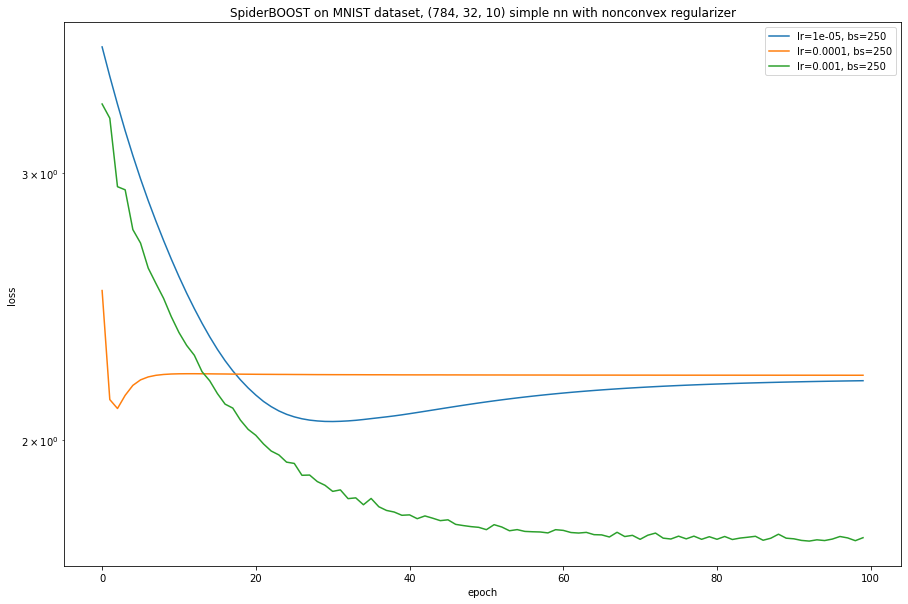

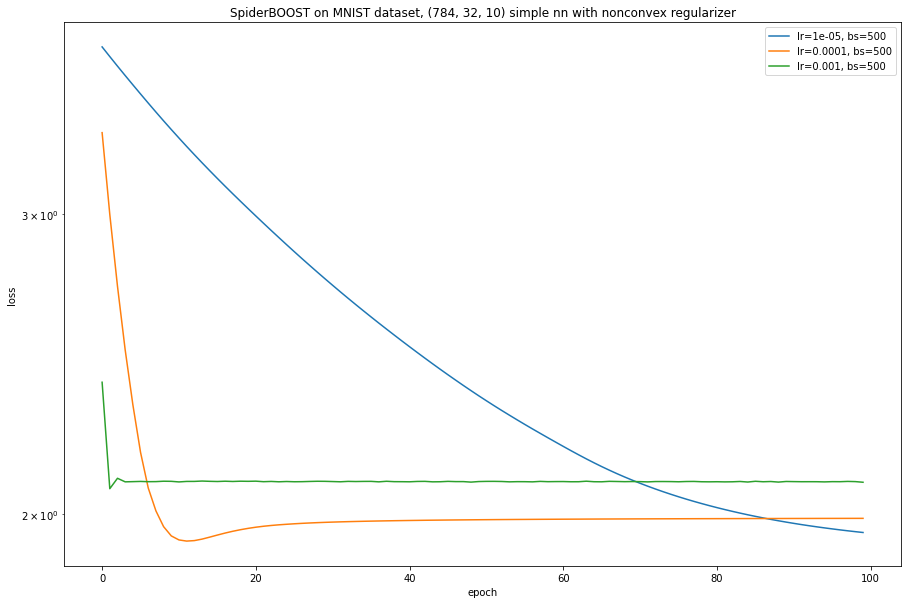

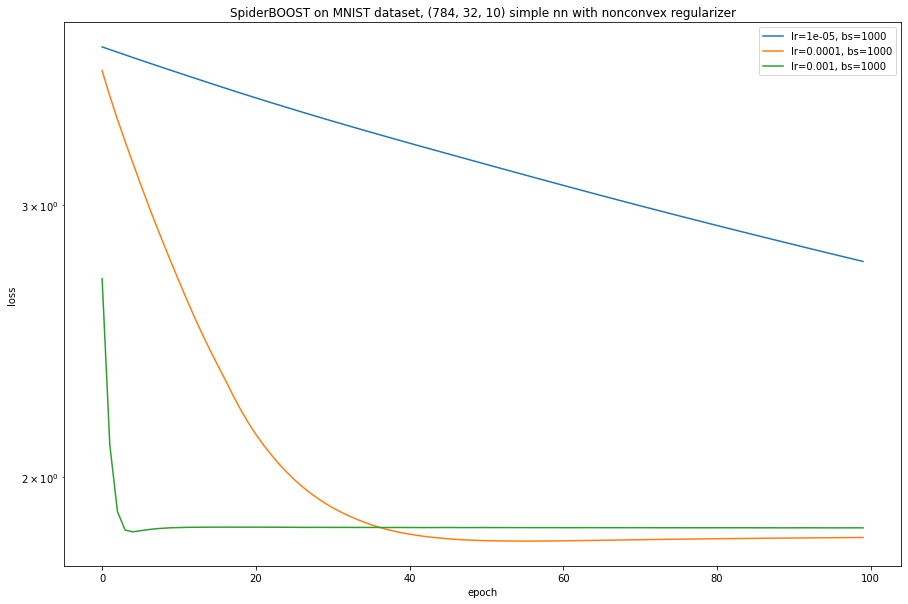

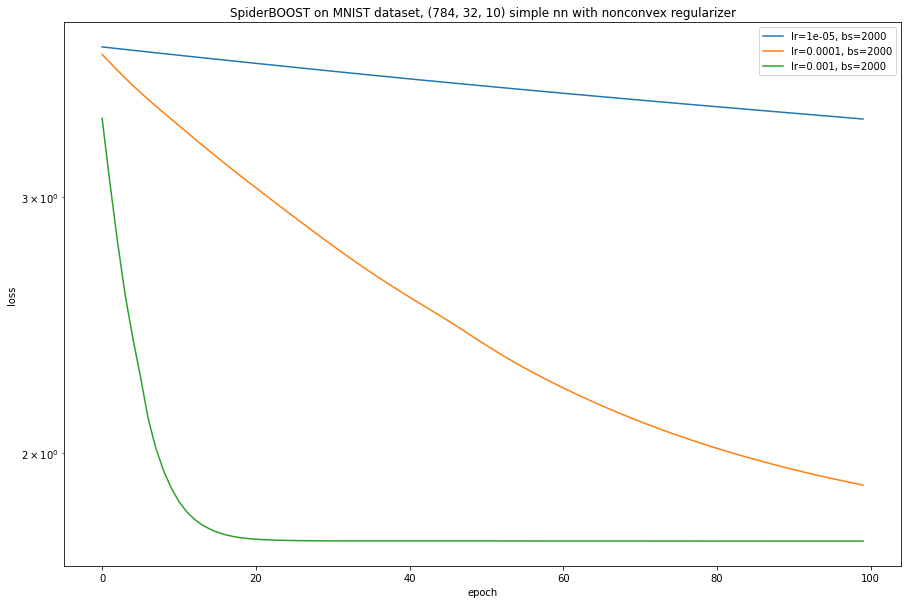

In [15]:
for bs in BS:
    plt.figure(figsize = (15,10))
    plt.title("SpiderBOOST on MNIST dataset, (784, 32, 10) simple nn with nonconvex regularizer")
    for lr in LR:
        plt.plot(losses[lr, bs], label="lr="+str(lr)+", bs="+str(bs))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.semilogy()
    plt.savefig("sp_bs_"+str(bs)+".png")
